In [50]:
import string
import re
import math
import pandas as pd
import numpy as np

from functools import reduce
from collections import Counter
from copy import deepcopy
from collections import defaultdict
from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

In [51]:
def get_docs(delimiter='%'):
    with open('documents.txt') as f:
        documents = f.read()
    
    # Return all documents except the last because that's empty string
    return documents.split(delimiter)[:-1]

def remove_punctuations(docs):
    return list(map(lambda s: re.sub(r"[^\w\d'\s]+",'',s), docs))

def remove_next_tab_chars(docs):
    return list(map(lambda s: s.replace('\n', ' ').replace('\t', ' '), docs))

def remove_extra_whitespaces(docs):
    return list(map(lambda s: ' '.join(s.split()), docs))


In [52]:
parsers = [remove_punctuations, remove_next_tab_chars, remove_extra_whitespaces]

documents = get_docs()
documents = reduce(lambda res, f: f(res), parsers, documents)

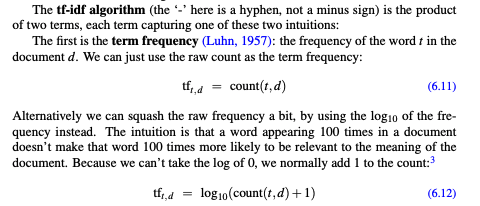

In [53]:
def get_term_frequencies(docs):
    tfreq = {}
    tfreqlog = {}
    
    for i, doc in enumerate(docs):
        tfd = Counter(doc.split())
        tfreq[i] = tfd
        
        tfdlog = deepcopy(tfd)
        
        # Take log10 of all the counts to normalize
        for k, v in tfdlog.items():
            tfdlog[k] = math.log10(v + 1)
            
        tfreqlog[i] = tfdlog
    
    return tfreq, tfreqlog

def get_normalized_term_frequencies(docs):
    tfreq = {}
    tfreq_norm = {}
    
    for i, doc in enumerate(docs):
        words = doc.split()
        doc_length = len(words)
        tfd = Counter(words)
        tfreq[i] = tfd
        
        tfdnorm = deepcopy(tfd)
        for k, v in tfdnorm.items():
            tfdnorm[k] /= doc_length
        
        tfreq_norm[i] = tfdnorm
    
    return tfreq, tfreq_norm

In [54]:
tfreq_d, tfreq_norm = get_normalized_term_frequencies(documents)

In [55]:
N = len(documents)  # 720
print(N)

def get_vocab(docs):
    words = []
    for doc in docs:
        words.extend(doc.split())
    
    terms = OrderedDict.fromkeys(words).keys()
    return terms, len(terms)

def get_idfs(docs, terms, tfreq_d, N):
    idf = {}
    
    for term in terms:
        df_t = 0
        for i, doc in enumerate(docs):
            if tfreq_d[i][term] > 0:
                df_t += 1
        
        idf[term] = math.log10(N/df_t)
    
    return idf

720


In [56]:
terms, vocab_size = get_vocab(documents)

idfs = get_idfs(documents, terms, tfreq_d, N)

In [57]:
def get_word_term_doc_matrix(terms, docs, tfreq_norm, idf):
    word_term_doc = []
    for term in terms:
        scores = [term]
        for i, doc in enumerate(documents):
            scores.append(tfreq_norm[i][term] * idf[term])

        word_term_doc.append(scores)
    
    return word_term_doc

def convert_to_df(word_term_doc, N):
    columns = ['term'] + [i for i in range(N)]
    return pd.DataFrame(word_term_doc, columns=columns).set_index(['term'])

In [58]:
word_term_doc = get_word_term_doc_matrix(terms, documents, tfreq_norm, idfs)
df = convert_to_df(word_term_doc, N)

In [59]:
def get_euclid_df_sklearn(df):
    no_index = df.reset_index(drop=True)
    values = [no_index.values[i] for i in range(N)]
    dist = euclidean_distances(values)
    return pd.DataFrame(dist)

def get_euclid_df_scipy(df):
    no_index = df.reset_index(drop=True)
    values = [no_index.values[i] for i in range(N)]
    dist = pdist(values, 'euclidean')
    return pd.DataFrame(squareform(dist))

In [60]:
euclid1 = get_euclid_df_sklearn(df)
euclid1

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,0.000000,0.274378,0.283761,0.215494,0.275419,0.278402,0.195860,0.206000,0.269989,0.259137,...,0.194643,0.179031,0.178402,0.192308,0.211491,0.178402,0.178402,0.181253,0.182750,0.203525
1,0.274378,0.000000,0.388463,0.148676,0.381268,0.390853,0.204037,0.296764,0.366080,0.354744,...,0.339362,0.330654,0.330314,0.338027,0.349298,0.330314,0.330314,0.331863,0.332683,0.344533
2,0.283761,0.388463,0.000000,0.323318,0.309902,0.249656,0.294982,0.294060,0.310931,0.313236,...,0.268001,0.263296,0.263275,0.270473,0.283932,0.263275,0.263275,0.262885,0.264338,0.279199
3,0.215494,0.148676,0.323318,0.000000,0.322600,0.321744,0.162339,0.229417,0.294265,0.264457,...,0.254302,0.242560,0.242097,0.252519,0.267417,0.242097,0.242097,0.244205,0.245318,0.261162
4,0.275419,0.381268,0.309902,0.322600,0.000000,0.273553,0.290694,0.289954,0.321563,0.309328,...,0.270901,0.259591,0.259366,0.267187,0.275057,0.259366,0.259366,0.260330,0.262101,0.265569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.178402,0.330314,0.263275,0.242097,0.259366,0.228472,0.196989,0.157727,0.220804,0.209868,...,0.078714,0.017639,0.000000,0.055110,0.114785,0.000000,0.000000,0.034095,0.041751,0.099411
716,0.178402,0.330314,0.263275,0.242097,0.259366,0.228472,0.196989,0.157727,0.220804,0.209868,...,0.078714,0.017639,0.000000,0.055110,0.114785,0.000000,0.000000,0.034095,0.041751,0.099411
717,0.181253,0.331863,0.262885,0.244205,0.260330,0.228375,0.199575,0.160945,0.223114,0.212297,...,0.085647,0.029803,0.034095,0.063105,0.119550,0.034095,0.034095,0.000000,0.053635,0.104866
718,0.182750,0.332683,0.264338,0.245318,0.262101,0.229124,0.200935,0.162628,0.221779,0.213576,...,0.088938,0.045122,0.041751,0.072294,0.121905,0.041751,0.041751,0.053635,0.000000,0.107541


In [61]:
euclid1.sort_values(713)

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
713,0.192308,0.338027,0.270473,0.252519,0.267187,0.237878,0.209666,0.173300,0.232184,0.221810,...,0.097911,0.054389,0.055110,0.000000,0.130076,0.055110,0.055110,0.063105,0.072294,0.116879
711,0.179031,0.330654,0.263296,0.242560,0.259591,0.228604,0.197558,0.158438,0.221312,0.210403,...,0.080576,0.000000,0.017639,0.054389,0.116007,0.017639,0.017639,0.029803,0.045122,0.100813
716,0.178402,0.330314,0.263275,0.242097,0.259366,0.228472,0.196989,0.157727,0.220804,0.209868,...,0.078714,0.017639,0.000000,0.055110,0.114785,0.000000,0.000000,0.034095,0.041751,0.099411
715,0.178402,0.330314,0.263275,0.242097,0.259366,0.228472,0.196989,0.157727,0.220804,0.209868,...,0.078714,0.017639,0.000000,0.055110,0.114785,0.000000,0.000000,0.034095,0.041751,0.099411
712,0.178402,0.330314,0.263275,0.242097,0.259366,0.228472,0.196989,0.157727,0.220804,0.209868,...,0.078714,0.017639,0.000000,0.055110,0.114785,0.000000,0.000000,0.034095,0.041751,0.099411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0.475597,0.550884,0.473376,0.500480,0.479121,0.443665,0.481678,0.465779,0.471032,0.460723,...,0.445621,0.442053,0.441799,0.447595,0.452016,0.441799,0.441799,0.442958,0.442288,0.448300
37,0.479037,0.553856,0.498562,0.506221,0.510867,0.488712,0.486265,0.471477,0.489742,0.491624,...,0.452249,0.445752,0.445500,0.451249,0.459752,0.445500,0.445500,0.446650,0.447259,0.456142
36,0.501971,0.573807,0.519718,0.527975,0.532191,0.510975,0.508873,0.495000,0.514911,0.513996,...,0.476474,0.470312,0.470073,0.475524,0.483601,0.470073,0.470073,0.471162,0.471740,0.480170
227,0.663058,0.718976,0.690114,0.682956,0.689518,0.673551,0.668299,0.657797,0.675702,0.672208,...,0.643971,0.639425,0.639249,0.643269,0.648513,0.639249,0.639249,0.640051,0.640476,0.646711


In [62]:
def get_similarity_df(euclid_df, N):
    similarities = []
    for i in range(N):
        for j in range(i+1, N):
            dist = euclid_df[i][j] 
            similarities.append((i, j, dist))
    
    return pd.DataFrame(similarities)

In [63]:
similarities = get_similarity_df(euclid1, N)

In [64]:
similarities = similarities.sort_values(2)
similarities

,0,1,2
128536,209,211,0.000000
257411,666,669,0.000000
250718,592,599,0.000000
250719,592,600,0.000000
250724,592,605,0.000000
...,...,...,...
33562,48,227,0.744295
26126,37,227,0.778646
26078,37,179,0.779914
25444,36,227,0.792961


In [47]:
luigi = pd.read_csv('code/pipeline/data/2020-11-18/similarity.csv')

In [49]:
luigi

,0,1,2
0,209,211,0.000000
1,666,669,0.000000
2,592,599,0.000000
3,592,600,0.000000
4,592,605,0.000000
...,...,...,...
258835,48,227,0.744295
258836,37,227,0.778646
258837,37,179,0.779914
258838,36,227,0.792961


In [66]:
OrderedDict.fromkeys(['aaa', 'test', 'test', 'aaa', 'vvv']).keys()

odict_keys(['aaa', 'test', 'vvv'])